## Experiments

Code for reproducing experiments shown in the paper

## Imports

In [1]:
import apoNN.src.data as apoData
import apoNN.src.utils as apoUtils
import apoNN.src.vectors as vectors
import apoNN.src.fitters as fitters
import apoNN.src.evaluators as evaluators
import apoNN.src.occam as occam_utils

import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
from ppca import PPCA
import inspect

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


we use the [```apogee```](https://github.com/jobovy/apogee) module for interacting with APOGEE data and make use of dr16

In [2]:
import apogee.tools.path as apogee_path
apogee_path.change_dr(16)

### Hyperparameters

For speed we can run the results using only a subset of spectra

In [3]:
n_start = 0
n_stars = 100000
d = 100 #number of dimensions to use for compression
tol = 0.01 # tolerance to use for PPCA. Larger means faster but less accurate

## Setup

We load the AllStar file and make appropriate datacuts. This yields ```alllStar_occamlike``` - a large dataset containing all those spectra matching the dataset cuts in the data release 16 - and ```allStar_occam``` containing those stars within ```alllStar_occamlike``` cross-matched with the occam open cluster dataset.

In [4]:
allStar = apoUtils.load("shuffled_allStar")


In [5]:
upper_temp_cut = allStar["Teff"]<5000
lower_temp_cut = allStar["Teff"]>4000
lower_g_cut = allStar["logg"]>1.5
upper_g_cut = allStar["logg"]<3.
occamlike_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut
allStar_occamlike =  allStar[np.where(occamlike_cut)]


occam = occam_utils.Occam()
occam_kept = occam.cg_prob>0.8
allStar_occam,cluster_idxs = occam_utils.prepare_occam_allStar(occam_kept,allStar_occamlike)



We convert allStar files into the continuum-normalized spectra using ```apoData.Dataset```

In [6]:
data_occamlike = apoData.Dataset(allStar_occamlike[n_start:n_start+n_stars])
data_occam = apoData.Dataset(allStar_occam)


```cluster_idxs``` contains the clusters to which entries in ```data_occam``` belong

In [7]:
assert(cluster_idxs.shape[0] == data_occam.masked_spectra.shape[0])

## Compression

```apoData.Dataset``` returns spectra for which bins with errors above a threshold are masked. We run a PCA that naturally handles missing values using the [ppca module](https://github.com/allentran/pca-magic). This is wrapped in a function ```fitters.compress_masked_spectra``` 

In [8]:
z,z_occam,ppca = fitters.compress_masked_spectra(data_occamlike.masked_spectra,data_occam.masked_spectra,d,tol=tol)


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds
/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:82: RuntimeWarning: divide by zero encountered in log
  det = np.log(np.linalg.det(Sx))


1.0
0.2711569327894485
0.007461904619951776
0.014363412660641672
0.0136451950761034
0.01166212339478967
0.010157160733870518
0.009092280431782562


As stated in the paper, our evaluation method requires using our approach on unseen clusters through a cross-validation scheme. This is handled through the ```evaluators.StandardEvaluator``` class which takes ```vectors.Vector``` as inputs. It is run as follows.

In [56]:
Z_occam = vectors.OccamVector(val = z_occam,cluster_names=cluster_idxs).remove_orphans()
Z = vectors.Vector(val = z)

The vectors come with lots of handy functions. For example we can see which stars belong to which clusters using ```vectors.OccamVector.registry``` or even remove a cluster using ```vectors.OccamVector.without()```

In [10]:
Z_occam.val.shape

(185, 100)

In [11]:
Z_occam.registry

{'Berkeley 98': array([14, 15, 16, 17]),
 'NGC 2682': array([84, 85, 86, 87, 88, 89, 90, 91]),
 'NGC 2158': array([47, 48, 49, 50, 51, 52, 53, 54]),
 'Berkeley 17': array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 'NGC 6819': array([135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163]),
 'Trumpler 5': array([178, 179, 180, 181, 182, 183, 184]),
 'NGC 7789': array([164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
        177]),
 'Berkeley 20': array([ 9, 10]),
 'NGC 1798': array([27, 28, 29, 30, 31, 32]),
 'NGC 6791': array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]),
 'NGC 6705': array([94, 95]),
 'NGC 4337': array([92, 93]),
 'NGC 2420': array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
 'NGC 2204': array([55,

In [12]:
Z_occam.without("NGC 6791").registry

{'Berkeley 98': array([14, 15, 16, 17]),
 'NGC 2682': array([84, 85, 86, 87, 88, 89, 90, 91]),
 'NGC 2158': array([47, 48, 49, 50, 51, 52, 53, 54]),
 'Berkeley 17': array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 'NGC 6819': array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124]),
 'Trumpler 5': array([139, 140, 141, 142, 143, 144, 145]),
 'NGC 7789': array([125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138]),
 'Berkeley 20': array([ 9, 10]),
 'NGC 1798': array([27, 28, 29, 30, 31, 32]),
 'NGC 6705': array([94, 95]),
 'NGC 4337': array([92, 93]),
 'NGC 2420': array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
 'NGC 2204': array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 'NGC 188': array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 'NGC 1193': array([25, 26]),
 'IC 1369': array([20, 21]),
 'NGC 2243': array([67, 68, 69, 70, 71]),
 'Czerni

## Baseline

As our baseline we use the AstroNN abundances. We use the ```vectors.AstroNNVector``` to create an AstroNN vector from an allStar file. Parameters included in the vector are passed through a ```considered_parameters``` input

In [13]:
considered_parameters = ["Fe_H","C_FE","N_FE","O_FE","Na_FE","Mg_FE","Al_FE","Si_FE","S_FE","K_FE","CA_FE","Ni_FE","Cr_FE","Co_FE"] 


In [14]:
Y = vectors.AstroNNVector(allStar_occamlike[n_start:n_start+n_stars],considered_parameters).remove_nan_cols()
#because one of the entries in the AstroNN catalogue contains nan. we remove it with Y.remove_nan_cols()
Y_occam = vectors.AstroNNVector(allStar_occam,considered_parameters)
Y_occam = vectors.OccamVector(cluster_names=cluster_idxs, val = Y_occam.val).remove_orphans()

In [15]:
print(inspect.getsource(vectors.AstroNNVector))

class AstroNNVector(Vector):
    def __init__(self,allStar,params):
        self.astroNN_hdul = fits.open("/share/splinter/ddm/modules/turbospectrum/spectra/dr16/apogee/vac/apogee-astronn/apogee_astroNN-DR16-v0.fits")
        self.allStar = allStar
        self.params = params
        ids = self.get_astroNN_ids(self.allStar)
        cut_astroNN = self.astroNN_hdul[1].data[ids]
        self._val = self.generate_abundances(cut_astroNN,self.params)
        
        
    def get_astroNN_ids(self,allStar):
        desired_ids= []
        astroNN_ids = list(self.astroNN_hdul[1].data["Apogee_id"])
        for apogee_id in allStar["APOGEE_ID"]:
            desired_ids.append(astroNN_ids.index(apogee_id))
        return desired_ids
    
    
    def generate_abundances(self,astroNN,params):
        values = []
        for i,p in enumerate(params):
            fe_h = astroNN["FE_H"]
            if p in ["Teff","logg","Fe_H"]:
                values.append(astroNN[p])
            else:
          

### Plotting performance against number of components

For our experiment we want to determine how performance compares with the number of dimensions preserved in the PCA step. We also want to compare against the performance obtained using abundances.

There are two ingredients required for assessing performance

- a ```fitters.Fitter``` object that takes vectors (spectra, stellar parameters) and scales them to encode chemical similarity. 

- a ```evaluators.Evaluator``` object that takes a fitter, and unsupervised dataset, an occam dataset and calculates the doppelganger rates of a representation.

In [16]:
print(inspect.getsource(evaluators.BaseEvaluator))

class BaseEvaluator(abc.ABC):
    """Base class from which all evaluators are derived. This is an abstract class so is never called directly."""
    def __init__(self,z,z_occam,leave_out=True):
        pass
    
    
    @abc.abstractmethod
    def get_distances(self):
        pass
    

    @staticmethod
    def get_combinations(len_cluster):
        """
        Given a cluster size returns a list containing every index combination forming valid pairs (without repeat pairs) 
        """
        combinations = []
        for idx1 in np.arange(len_cluster):
            for idx2 in np.delete(np.arange(len_cluster),idx1):
                if sorted([idx1,idx2]) not in combinations:
                    combinations.append(sorted([idx1,idx2]))
        return combinations
    
    
    @staticmethod
    def get_doppelganger_rate(distances,random_distances,registry):
        """
        INPUTS
        distances: nested list or array containing intracluster distances. len of upper list should m

In [17]:
def simple_fitter(z,z_occam):
    """This is a simple fitter that just scales the dimensions of the inputed representation. Which is used as a baseline"""
    return fitters.SimpleFitter(z,z_occam,use_relative_scaling=True,is_pooled=True,is_robust=True)


In [18]:
def standard_fitter(z,z_occam):
    """This fitter performs a change-of-basis to a more appropriate basis for scaling"""
    return fitters.StandardFitter(z,z_occam,use_relative_scaling=True,is_pooled=True)


In [19]:
evaluator_Y = evaluators.StandardEvaluator(Y,Y_occam,leave_out=True,fitter_class=standard_fitter)
evaluator_Y.weighted_average

0.022415915720714864

In [20]:
n_components = [5,15,25,35,45,55,65,75,85,95]
evaluators_X = [evaluators.StandardEvaluator(Z[:,:n_component],Z_occam[:,:n_component],leave_out=True,fitter_class=standard_fitter) for n_component in n_components]

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing O

we can pass ```leave_out=False``` in which case the (overfitted) results without cross-validation are shown

In [21]:
evaluators_X_overfit = [evaluators.StandardEvaluator(Z[:,:n_component],Z_occam[:,:n_component],leave_out=False,fitter_class=standard_fitter) for n_component in n_components]

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing O

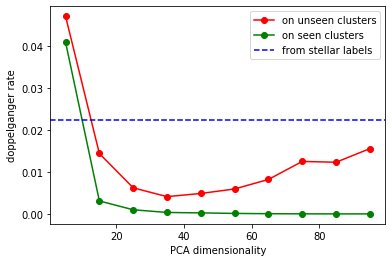

In [22]:
plt.plot(n_components,np.array([i.weighted_average for i in evaluators_X]),label="on unseen clusters",color="red",marker='o')
plt.plot(n_components,np.array([i.weighted_average for i in evaluators_X_overfit]),label="on seen clusters",color="green",marker='o')
plt.axhline(y=evaluator_Y.weighted_average,c="blue",linestyle  = "--",label="from stellar labels")
plt.ylabel("doppelganger rate")
plt.xlabel("PCA dimensionality")
plt.legend()
plt.savefig("../../figures/global_doppelganger.pdf",format="pdf")
#plt.title("Doppelganger rate per star")

### Fine grained investigation into cluster level performance

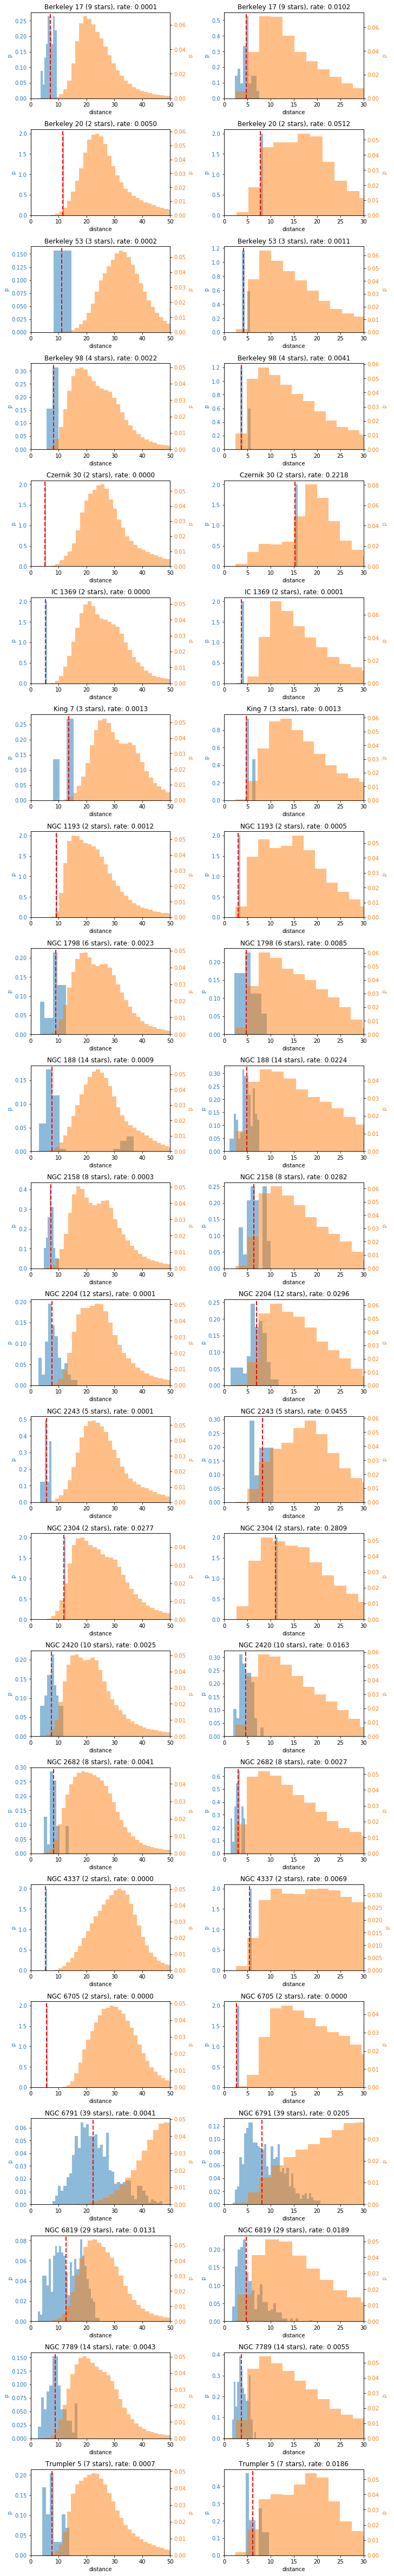

In [240]:
n_rows = 22
fig = plt.figure(constrained_layout=True,figsize=[10,3*n_rows])
gspec = gridspec.GridSpec(ncols=2, nrows=n_rows, figure=fig)
#for i in range(len(sorted(spectra_evaluator.registry))):
for i in range(n_rows):
    spec_ax = fig.add_subplot(gspec[i, 0])
    evaluators_X[3].plot_cluster(sorted(evaluators_X[3].registry)[i],spec_ax,x_max=50)
    abund_ax = fig.add_subplot(gspec[i, 1])
    evaluator_Y.plot_cluster(sorted(evaluator_Y.registry)[i],abund_ax)
    
plt.savefig("../../figures/local_doppelganger.pdf",format="pdf")


### Plotting performance against open clusters

We plot the performance obtained against the number of open-clusters used.

In [24]:
n_repeats = 20 #How many different combinations of clusters to sample for each size
n_clusters_considered = [10,15,20,22] #How many clusters to preserve
n_component = 25

In [25]:
def get_n_random_clusters(vector_occam,n_clusters):
    cluster_list = random.sample(list(vector_occam.registry),n_clusters)
    return vector_occam.only(cluster_list)

In [26]:
res = []
for n_clusters in n_clusters_considered:
    res.append([])
    for _ in range(n_repeats):
        Z_restricted = get_n_random_clusters(Z_occam,n_clusters)
        evaluator_X = evaluators.StandardEvaluator(Z[:,:n_component],Z_restricted[:,:n_component],leave_out=True,fitter_class=standard_fitter)
        res[-1].append(evaluator_X.weighted_average)

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing O

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing O

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing O

In [27]:
[np.mean(res_i) for res_i in res]

[0.014349504469392996,
 0.0084243136625726,
 0.006404907537525283,
 0.006272264864864865]

In [29]:
res_y = []
for n_clusters in n_clusters_considered:
    res_y.append([])
    for _ in range(n_repeats):
        Y_restricted = get_n_random_clusters(Y_occam,n_clusters)
        evaluator_Y = evaluators.StandardEvaluator(Y,Y_restricted,leave_out=True,fitter_class=standard_fitter)
        res_y[-1].append(evaluator_Y.weighted_average)

In [30]:
[np.mean(res_i) for res_i in res_y]

[0.028881909219667296,
 0.023759447506973834,
 0.02266472980525105,
 0.022415740039768754]

In [31]:
[np.mean(res_i) for res_i in res_y]

[0.028881909219667296,
 0.023759447506973834,
 0.02266472980525105,
 0.022415740039768754]

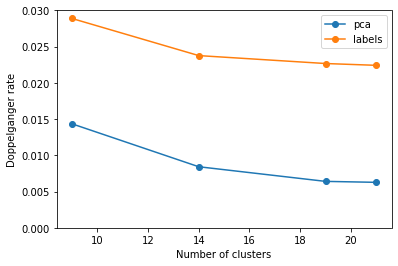

In [249]:
plt.plot(np.array(n_clusters_considered)-1,[np.mean(res_i) for res_i in res],label="pca",marker='o')
plt.plot(np.array(n_clusters_considered)-1,[np.mean(res_i) for res_i in res_y],label="labels",marker='o')

#np.array(n_clusters_considered)-1 because one cluster removed from scaling when evaluated on leave-out=True 

plt.xlabel("Number of clusters")
plt.ylabel("Doppelganger rate")
plt.ylim(0.,0.03)
plt.legend()
plt.savefig("../../figures/doppelganger_vs_clusters.pdf",format="pdf")


### Plotting performance against dataset size

We investigate how much the PCA compression is affected by the dataset size.

In [33]:
def get_Zs(data,data_occam,d,tol,n_stars = 1000):
    kept_idxs = np.random.choice(len(data.masked_spectra),n_stars,replace=False)
    z,z_occam,ppca = fitters.compress_masked_spectra(data.masked_spectra[kept_idxs],data_occam.masked_spectra,d,tol=tol)
    Z_occam = vectors.OccamVector(val = z_occam,cluster_names=cluster_idxs).remove_orphans()
    Z = vectors.Vector(val = z)
    return Z,Z_occam

In [34]:
dataset_sizes = [10000,20000,30000,40000,50000]
n_repeats = 5
d=25

In [35]:
res_datasize = []
for dataset_size in dataset_sizes:
    res_datasize.append([])
    for _ in range(n_repeats):
        Z,Z_occam = get_Zs(data_occamlike,data_occam,d=d,tol=0.1,n_stars = dataset_size)
        evaluator = evaluators.StandardEvaluator(Z,Z_occam,leave_out=True,fitter_class=standard_fitter)
        res_datasize[-1].append(evaluator.weighted_average)

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.7213046466842858
0.007818427274126849
0.023790445954228634
0.015413670893426157
0.010835730636780005
0.00807421823657306


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.6216473699361809
0.006427481980691763
0.02382928846101895
0.01699321273570087
0.011652750529281719
0.00787336321533405


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.4846910833399505
0.010873537257530597
0.023220559446596845
0.015141841084428176
0.010090721158433125
0.006791147142822251


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.5370205228291278
0.008643326123796813
0.022858005141215165
0.01545965093213375
0.010778136135298655
0.007653288113374401


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.6036501954807392
0.00872760836909603
0.02444607896149098
0.016376993358512948
0.011286983406848194
0.007972719557301278


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.634472728541456
0.00939912366867679
0.025491556783720948
0.017250452280825557
0.011874022686553909
0.008116540901779379


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.6051858007586275
0.006308633622772897
0.023697719009443508
0.015879049007174517
0.010925966922844421
0.007810013025155049


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.6216563961028125
0.008741129959018767
0.023988956112176774
0.015081776797945867
0.010522263489035955
0.007592850039286891


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.6251958317560407
0.0077742617916808365
0.025437984889201792
0.01732998310802325
0.01137375560486098
0.007578810141377401


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.5947836210898063
0.010625900067068761
0.02379537838153467
0.01553347595613419
0.011314712329573484
0.008306721718083221


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.5798569580576072
0.010906854028755353
0.02492988253062578
0.015863248587159928
0.010229990520708165
0.006540858332816701


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.5142708344925333
0.009862675473303217
0.02306455053329548
0.01578879177610315
0.01054787137434765
0.006826468950379416


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.5967365792083956
0.008765657697099583
0.024356244997297827
0.016335739062856902
0.011326319430858933
0.007661942655056264


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.7073946912401994
0.007428879845835401
0.023936732625523982
0.01594291499962064
0.010720692893172346
0.007530186881402612


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.5767303138037696
0.007657233935184249
0.022471393837320774
0.015497794530985098
0.010905250575200642
0.0077126456413920685


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.4958349515383189
0.011921190611458687
0.023863210852320016
0.015214598287140557
0.010217882677986512
0.007431591007066252


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.546586956570623
0.012310072045932485
0.025234594249210707
0.016569149373180325
0.011719274814407377
0.008239535670250264


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.5321963066464981
0.010384498185745383
0.024285496516227134
0.016566278547087476
0.01133679352261685
0.007514652746884565


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.5060344576422222
0.012766318376546515
0.024173944093925592
0.016445651226982716
0.011235397510671818
0.007354496865217941


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.5925533755955463
0.008630406767318188
0.023898406361711144
0.015534222900993044
0.010864386134274873
0.008457896604300963


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.660172401239117
0.008531937588615257
0.0246405836070287
0.015720166528859658
0.01050625352234924
0.007803357293039492


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.5447642527217293
0.00761229876410241
0.02417024895330444
0.015994546852965863
0.011134852294012676
0.008273032595224161


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.5518692049716676
0.00960307497996249
0.02335190901724571
0.015371695703553678
0.011041080149334137
0.00821904988577804


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.6231739370640772
0.007669820398916172
0.023559333414744144
0.015165994613771772
0.010787364942468014
0.008456946476363303


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


1.0
0.7537901752920007
0.0051132602340776545
0.02523439684709239
0.017012513236278615
0.011989671185995365
0.008491871799650053


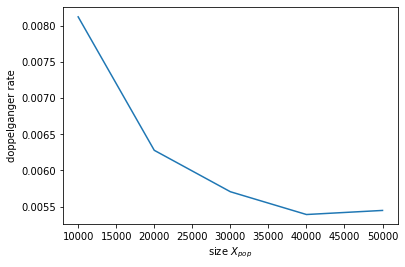

In [257]:
plt.plot(dataset_sizes,np.mean(np.array(res_datasize).reshape(5,5),axis=1))
plt.xlabel(r"size $X_{pop}$")
plt.ylabel("doppelganger rate")
plt.savefig("../../figures/doppelganger_vs_Xsize.pdf",format="pdf")


In [37]:
res_datasize[1]

[0.006165675675675677,
 0.006263513513513513,
 0.0065227027027027025,
 0.006254864864864865,
 0.0061897297297297295]

In [38]:
kept_idxs = np.random.choice(len(data_occamlike.masked_spectra),100,replace=False)
kept_idxs

array([85450,  7292,  7662,  6051, 43600, 80885, 60956,  9722, 35559,
       56208, 33097, 35179, 84261, 55807,  1210, 59081,  4555, 81762,
       43936, 69037,  3575, 71929, 26139, 88851, 20458, 69946, 62520,
       96955,  8030, 91987, 62345, 29858, 59282, 23047, 74682, 16704,
        8869, 38462, 61048, 39766, 18503, 22280, 18393, 24435, 41514,
       85180, 38924, 50071, 42652, 80520, 53101, 36835, 22364, 96628,
       89926, 51018, 82078, 86789, 49633, 77063, 10641, 25732, 40586,
       82471, 42502, 42100, 36104, 16116, 38448, 87714, 68163, 94320,
       42654, 68541, 53219, 77471,  5756, 77129, 59661, 21903, 57219,
       62131,  5212, 92782, 58207, 33010, 65792, 27280, 10852, 71778,
       58913, 64111, 86680, 41412, 51819, 89651, 60868, 43218, 37453,
       57470])

In [39]:
data_occamlike.masked_spectra[kept_idxs]

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)

In [40]:
data_occamlike.masked_spectra[0:100]

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)

### Measure correlation between similarity and other parameters

In [41]:
Ytest = vectors.AstroNNVector(allStar_occamlike[n_start:n_start+n_stars],considered_parameters)

In [61]:
Z_occam.registry

{'Berkeley 98': array([14, 15, 16, 17]),
 'NGC 2682': array([84, 85, 86, 87, 88, 89, 90, 91]),
 'NGC 2158': array([47, 48, 49, 50, 51, 52, 53, 54]),
 'Berkeley 17': array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 'NGC 6819': array([135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163]),
 'Trumpler 5': array([178, 179, 180, 181, 182, 183, 184]),
 'NGC 7789': array([164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
        177]),
 'Berkeley 20': array([ 9, 10]),
 'NGC 1798': array([27, 28, 29, 30, 31, 32]),
 'NGC 6791': array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]),
 'NGC 6705': array([94, 95]),
 'NGC 4337': array([92, 93]),
 'NGC 2420': array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
 'NGC 2204': array([55,

In [62]:
Y_fitter = standard_fitter(Y,Y_occam.without('NGC 6791'))
v_y = Y_fitter.transform(Y_fitter.z.centered(Y_occam)).val


In [63]:
z_dim = 30
Z_fitter = standard_fitter(Z[:,:z_dim],Z_occam[:,:z_dim].without('NGC 6791'))
v_z = Z_fitter.transform(Z_fitter.z.centered(Z_occam[:,:z_dim])).val


/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")


In [64]:
def similarity(i,j,v):
    return np.linalg.norm(v[i]-v[j])

In [236]:
#param = considered_parameters[1]
#param = "AK_TARG"
#param = considered_parameters[0]

param = "meanfib"
y_interest = allStar_occamlike[n_start:n_start+n_stars][param][np.isnan(Ytest.val)[:,0]==False]

In [237]:
y_interest.shape

(99997,)

In [238]:
similarity_y = []
similarity_z = []

difference_list = []
for _ in range(10000):
    i,j = np.random.choice(100,2)
    #if similarity(i,j,v_z)<100:
    similarity_y.append(similarity(i,j,v_y))
    similarity_z.append(similarity(i,j,v_z))
    difference_list.append(np.abs(y_interest[i]-y_interest[j]))

IndexError: index 96 is out of bounds for axis 0 with size 56

ValueError: x and y must be the same size

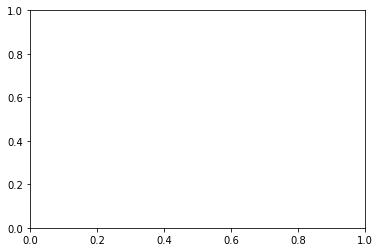

In [239]:
plt.scatter(difference_list,similarity_y,s=0.01,color="r")
plt.plot(difference_list,np.poly1d(np.polyfit(difference_list, similarity_y, 1))(difference_list),color="r",label="from labels")
plt.scatter(difference_list,similarity_z,s=0.01,color="b")
plt.plot(difference_list,np.poly1d(np.polyfit(difference_list, similarity_z, 1))(difference_list),color="b",label="from spectra")
plt.legend()
plt.title(param)
plt.ylabel("chemical similarity")
plt.xlabel(param+" diff")


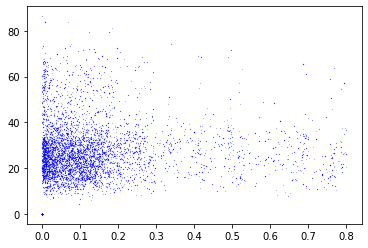

In [50]:
plt.scatter(difference_list,similarity_z,s=0.01,color="b")
#plt.plot(difference_list,np.poly1d(np.polyfit(difference_list, similarity_z, 1))(difference_list),color="b",label="from spectra")

In [215]:
same_field_ids = np.where(allStar_occamlike["field"][n_start:n_start+n_stars]=='225-04')[0]
different_field_ids = np.random.choice(100000,len(same_field_ids))

In [216]:
Z[same_field_ids].val.shape

(97, 100)

In [217]:
Z_diff = Z[different_field_ids,:z_dim]
v_z_diff = Z_fitter.transform(Z_diff.centered(Z_occam[:,:z_dim])).val


/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")


In [218]:
Y_diff = Ytest[different_field_ids]
v_y_diff = Y_fitter.transform(Y_diff.centered(Y_occam)).val


In [219]:
Y_same = Ytest[same_field_ids]
v_y_same = Y_fitter.transform(Y_same.centered(Y_occam)).val


In [220]:
Z_same = Z[same_field_ids,:z_dim]
v_z_same = Z_fitter.transform(Z_same.centered(Z_occam[:,:z_dim])).val


/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")


In [221]:
def get_intra(v_z):
    combinations = evaluators.BaseEvaluator.get_combinations(len(v_z))
    distances_cluster = []
    for combination in combinations:
        distances_cluster.append(np.linalg.norm(v_z[combination[0]]-v_z[combination[1]]))
    return distances_cluster


In [222]:
allStar_occamlike["field"]

chararray(['LAMBDAORI-C', '000+75', '140-12', ..., 'K17_072+13',
           'K17_072+13', '214+12'], dtype='<U16')

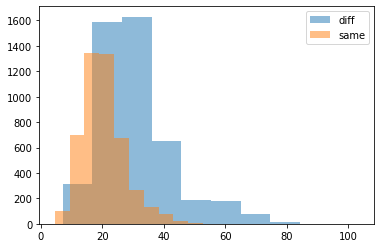

In [223]:
plt.hist(get_intra(v_z_diff), alpha = 0.5,label="diff")#plt.hist(distances_cluster, alpha = 0.5)
plt.hist(get_intra(v_z_same), alpha = 0.5,label="same")#plt.hist(distances_cluster, alpha = 0.5
plt.legend()

In [224]:
## need to correct for the fact that Y is different sized or make Y the same size

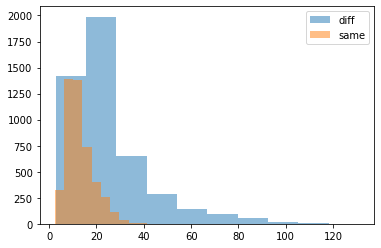

In [225]:
plt.hist(get_intra(v_y_diff), alpha = 0.5,label="diff")#plt.hist(distances_cluster, alpha = 0.5)
plt.hist(get_intra(v_y_same), alpha = 0.5,label="same")#plt.hist(distances_cluster, alpha = 0.5
plt.legend()

In [226]:
Z.val.shape

(100000, 100)

In [235]:
np.where(allStar_occam["MEANFIB"])

(array([], dtype=int64),)